### Simple Random Forest ! for original dataset!


Model Evaluation:
Accuracy: 0.2642
Precision (weighted): 0.2484
Recall (weighted): 0.2642
F1-score (weighted): 0.2456
ROC AUC Score: 0.9396


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Cross-validation scores: [0.20305481 0.23989218 0.21582734 0.19694245 0.23201439]
Mean CV score: 0.2175 (+/- 0.0328)

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.20      0.17      0.18         6
       Active       0.00      0.00      0.00         6
        Adult       0.00      0.00      0.00         2
        Agile       0.09      0.14      0.11         7
     Alluring       0.38      0.45      0.42        11
      Amiable       0.09      0.20      0.12         5
      Amusing       0.33      0.17      0.22         6
      Aqueous       0.00      0.00      0.00         4
 Aristocratic       0.00      0.00      0.00         4
     Aromatic       0.00      0.00      0.00         5
     Artistic       0.00      0.00      0.00         1
Authoritative       0.00      0.00      0.00         4
       Bitter       0.67      0.50      0.57         4
      Bitterl       0.00      0.00      0.00         1
         Bold       0.00      0.

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


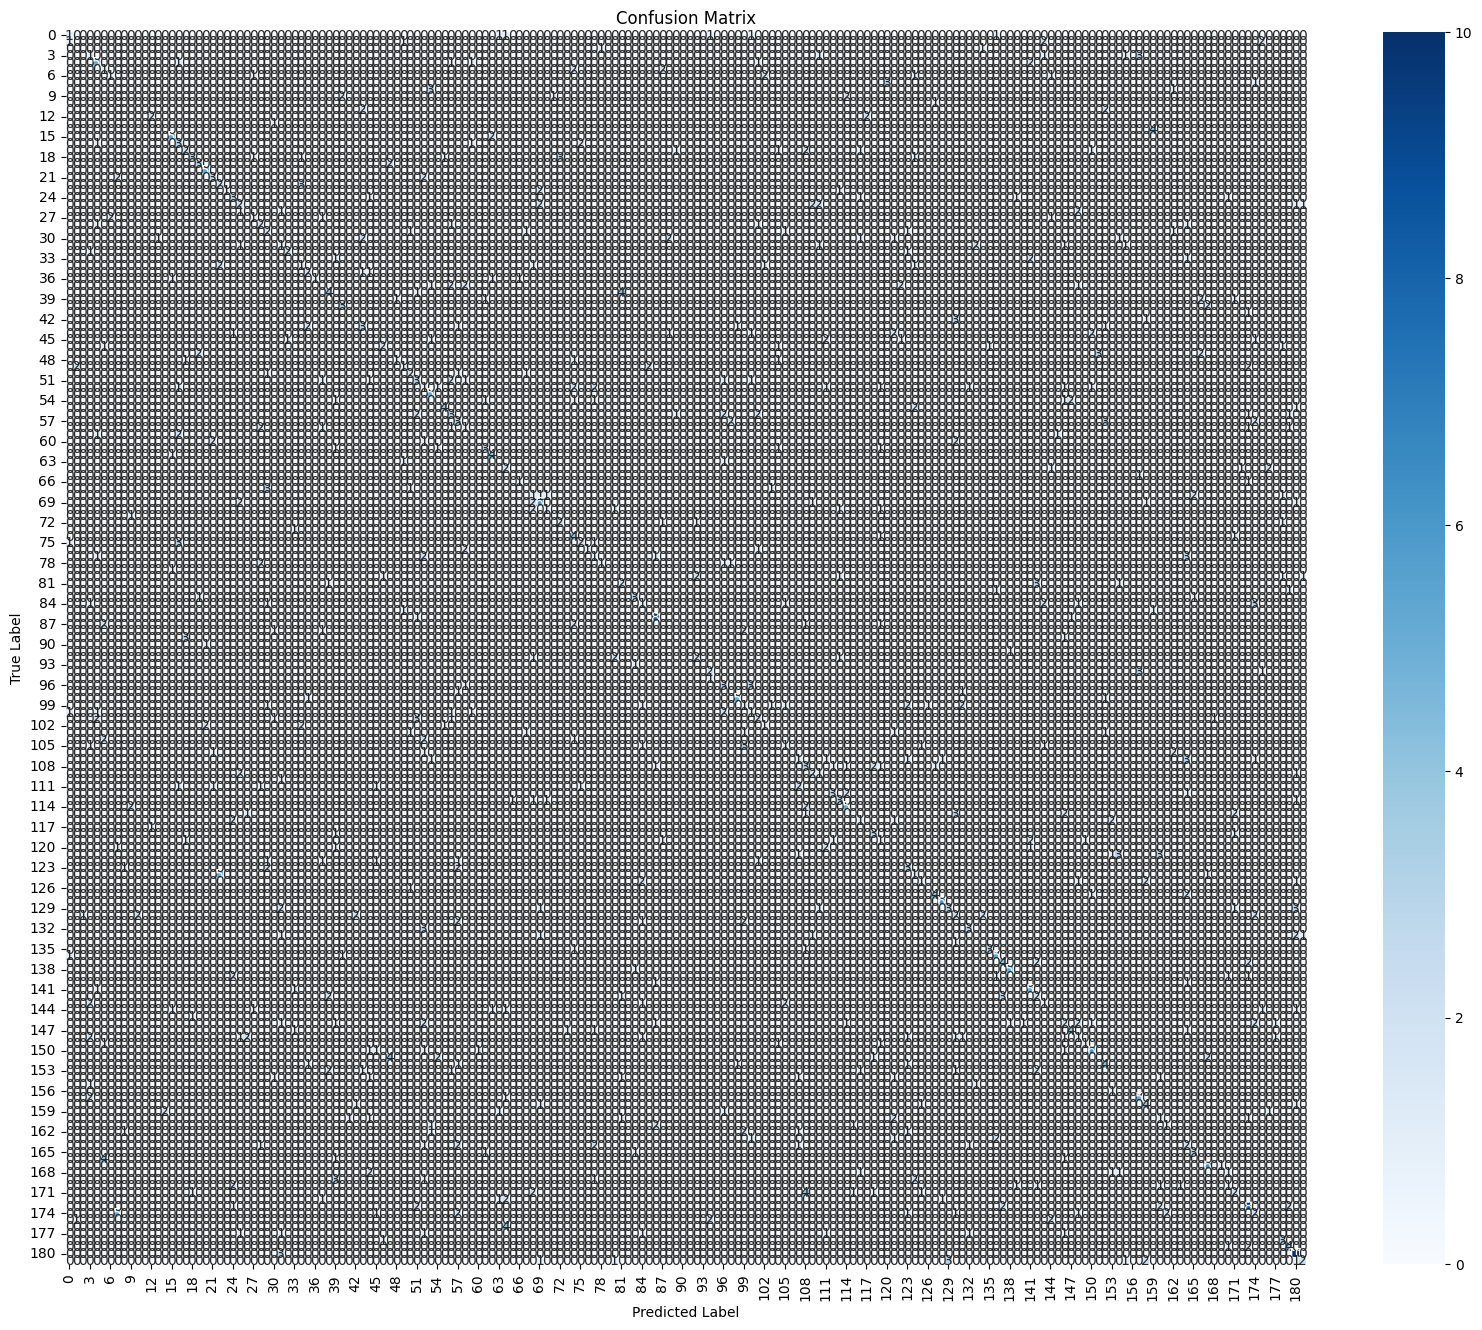

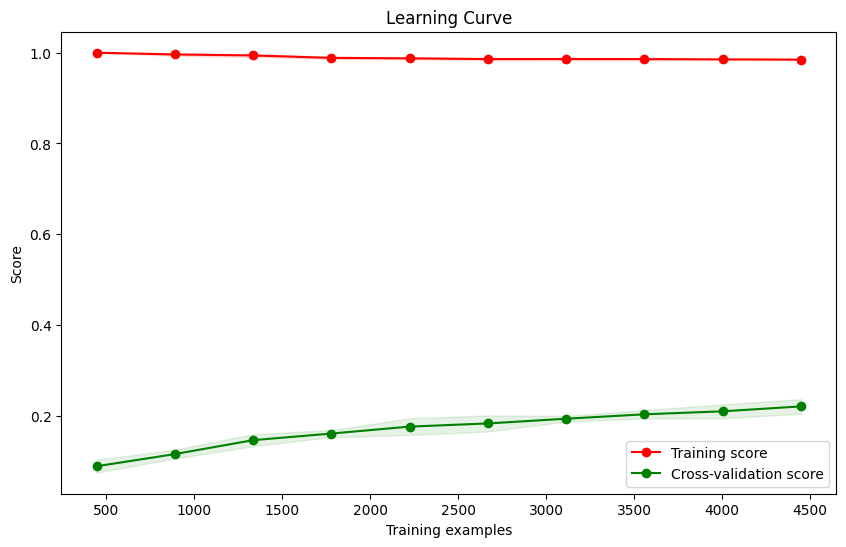


Model Fit Assessment:
Train Accuracy: 0.9838
Validation Accuracy: N/A
Test Accuracy: 0.2642

Difference between Train and Test accuracy: 0.7197

Number of parameters: 44474200


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv(r'C:\Biography\ArtEmotionalPalette-AI\PartA-model\datasets\x6perfect_cleaned.csv')
X = data.iloc[:, 1:].values / 255.0  # Features (RGB values), normalized
y = data.iloc[:, 0].values # Target variable

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y) # Transform string labels to numeric values

# Split the data into training and testing sets
# stratify=y ensures that the proportion of samples for each class is roughly the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test) # Probability estimates for each class

# Evaluate the model
print("Model Evaluation:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Print overfitting/underfitting assessment
print("\nModel Fit Assessment:")
train_accuracy = rf_classifier.score(X_train, y_train)
test_accuracy = rf_classifier.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: N/A")  # Random Forest doesn't have a separate validation set
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nDifference between Train and Test accuracy: {abs(train_accuracy - test_accuracy):.4f}")

if train_accuracy - test_accuracy > 0.1:
    print("Warning: Large gap between training and test accuracies suggests overfitting.")
elif train_accuracy < 0.8:
    print("Warning: Low training accuracy suggests underfitting.")
else:
    print("Model performance on training and test sets is consistent.")

# Model complexity
n_params = rf_classifier.n_estimators * np.sum([tree.tree_.node_count for tree in rf_classifier.estimators_])
print(f"\nNumber of parameters: {n_params}")

### Simple Random Forest ! for SMOTE dataset


Model Evaluation:


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8742
Precision (weighted): 0.8737
Recall (weighted): 0.8742
F1-score (weighted): 0.8699
ROC AUC Score: 0.9964

Cross-validation scores: [0.83522232 0.85527463 0.93548387 0.93315897 0.92761628]
Mean CV score: 0.8974 (+/- 0.0862)

Classification Report:
                 precision    recall  f1-score   support

       Abundant       0.78      1.00      0.88        21
         Active       0.86      0.90      0.88        21
          Adult       0.91      1.00      0.95        21
          Agile       0.95      0.95      0.95        22
       Alluring       0.86      0.90      0.88        21
        Amiable       0.95      1.00      0.98        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       0.96      1.00      0.98        22
       Aromatic       0.85      1.00      0.92        22
       Artistic       0.96      1.00      0.98        22
  Authoritative       0.88      1.00      0.93        21
         Bitter       0.85      1.00      0.92     

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


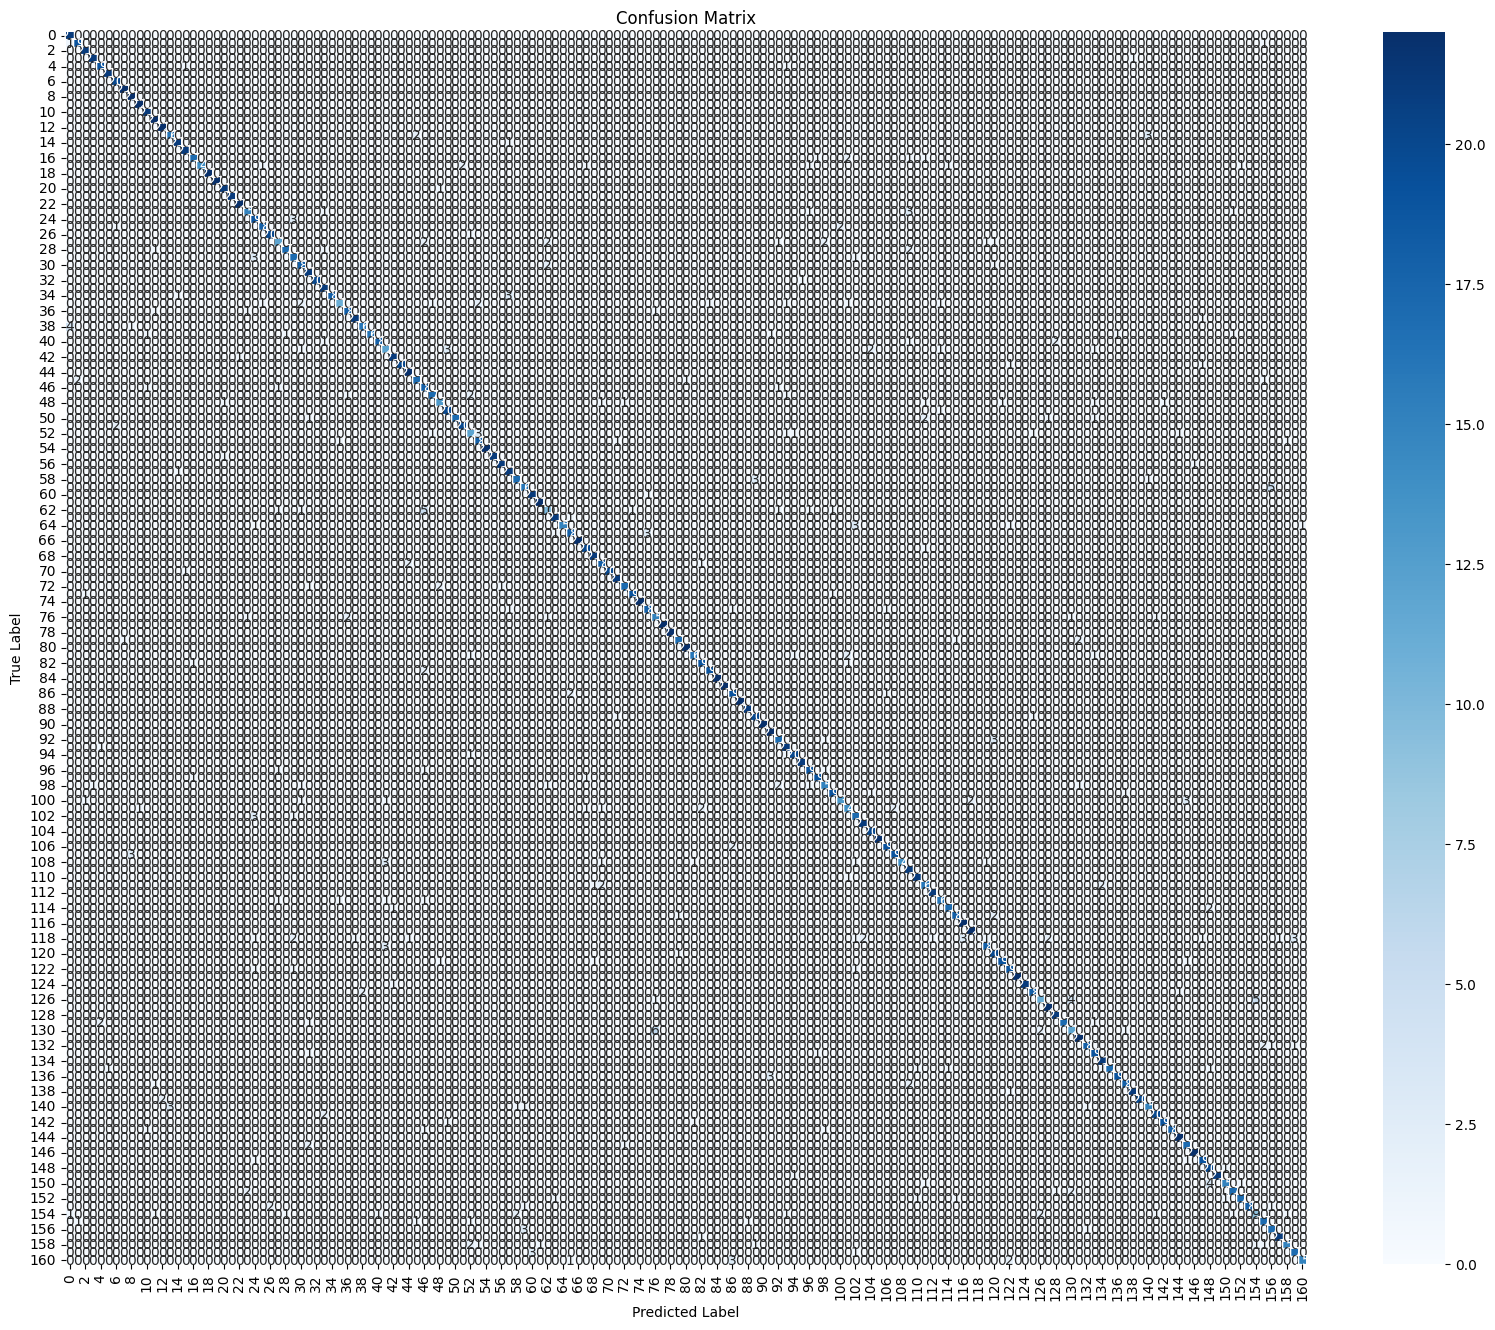

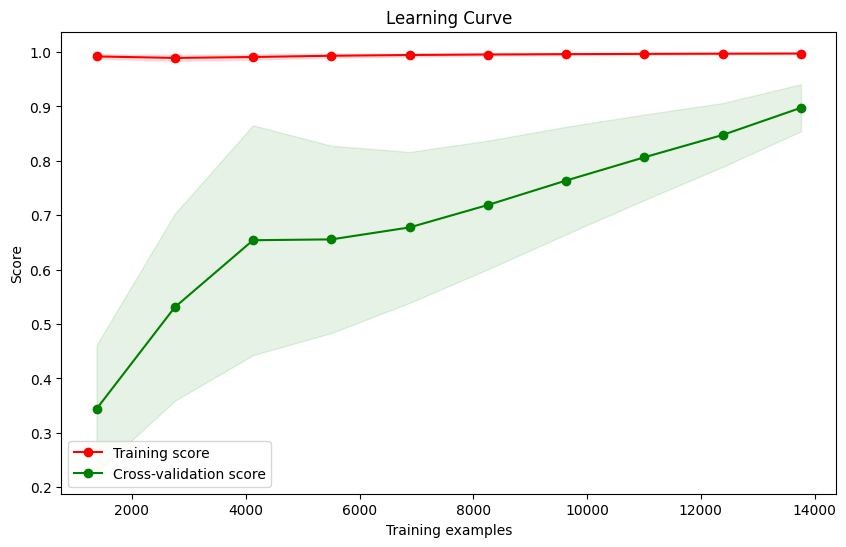


Model Fit Assessment:
Train Accuracy: 0.9976
Validation Accuracy: N/A
Test Accuracy: 0.8742

Difference between Train and Test accuracy: 0.1234

Number of parameters: 72391800


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0  # Features (RGB values), normalized
y = data.iloc[:, -1].values  # Target variable

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y) # Transform string labels to numeric values

# Split the data into training and testing sets
# stratify=y ensures that the proportion of samples for each class is roughly the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test) # Probability estimates for each class

# Evaluate the model
print("Model Evaluation:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Print overfitting/underfitting assessment
print("\nModel Fit Assessment:")
train_accuracy = rf_classifier.score(X_train, y_train)
test_accuracy = rf_classifier.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: N/A")  # Random Forest doesn't have a separate validation set
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nDifference between Train and Test accuracy: {abs(train_accuracy - test_accuracy):.4f}")

if train_accuracy - test_accuracy > 0.1:
    print("Warning: Large gap between training and test accuracies suggests overfitting.")
elif train_accuracy < 0.8:
    print("Warning: Low training accuracy suggests underfitting.")
else:
    print("Model performance on training and test sets is consistent.")

# Model complexity
n_params = rf_classifier.n_estimators * np.sum([tree.tree_.node_count for tree in rf_classifier.estimators_])
print(f"\nNumber of parameters: {n_params}")

### Analysis of Random Forest Model:

1. Model Architecture:

- Number of trees (n_estimators): 100
- Feature selection: All features used (no explicit feature selection)
- Number of parameters: 72,391,800 (extremely high, indicating complex trees)

2. Performance Metrics:

- Test Accuracy: 0.8742 (87.42%)
- Precision (weighted): 0.8737 (87.37%)
- Recall (weighted): 0.8742 (87.42%)
- F1-score (weighted): 0.8699 (86.99%)
- ROC AUC Score: 0.9964 (99.64%)
- Train Accuracy: 0.9976 (99.76%)
- Mean Cross-Validation Score: 0.8974 (89.74%)

3. Hyperparameter Configuration:

- n_estimators: 100 (default)
- Other parameters likely at default values (e.g., max_depth=None, min_samples_split=2)

4. Training Process:

- Used 5-fold cross-validation

5. Generalization:

- Poor generalization evidenced by: Large gap between training accuracy (99.76%) and test accuracy (87.42%)
- Cross-validation score (89.74%) higher than test accuracy, indicating some instability

6. Learning curve shows:

- Near-perfect training scores across all training set sizes
- Improving but consistently lower cross-validation scores
- Persistent gap between training and cross-validation scores

7. Bias-Variance Trade-off:

- Very low bias: Extremely high training accuracy (99.76%) shows the model captures patterns in training data almost perfectly
- High variance: Large gap between training and test accuracies (12.34 percentage points) indicates poor generalization
- Bias estimate: 1 - Training Accuracy = 1 - 0.9976 = 0.0024 (0.24%)
- The model has extremely low bias (about 0.24%), meaning it learns the training data patterns almost perfectly. However, it fails to generalize well to new data, indicating severe overfitting.

8. Class Performance:

- Many classes show excellent performance (precision and recall > 0.90)
- Worst performing classes:
  - Pure_Simplicity: 0.00 (F1-score)
  - Untamed: 0.50 (F1-score)
  - Formal: 0.54 (F1-score)
  - Distinguished: 0.60 (F1-score)
  - Robust: 0.61 (F1-score)

9. Model Complexity:

- Extremely high number of parameters (72,391,800) suggests very deep and complex trees

10. Connfusion Matrix:

- Strong diagonal pattern indicates good overall classification
- Some off-diagonal elements suggest misclassifications between certain emotion pairs
- Detailed analysis of misclassifications could provide insights into similar emotions

11. ROC AUC Score:

- Very high score (0.9964) indicates excellent discriminative ability
- Suggests that despite overfitting, the model has learned meaningful patterns for ranking predictions

12. Cross-validation Stability:

- Cross-validation scores: [0.8352, 0.8553, 0.9355, 0.9332, 0.9276]
- Standard deviation: 0.0431 (4.31%)
- Indicates some variability in model performance across different subsets of the data

13. Overfitting Indicators:

- Large gap between train and test accuracy (12.34 percentage points)
- Near-perfect training accuracy (99.76%)
- Learning curve showing persistent gap between training and cross-validation scores

* Potentila Improvements
  limit tree depth, increase min_samples_leaf)
  Address class imbalance (e.g., class weighting, resampling techniques)
  Hyperparameter tuning using techniques like RandomizedSearchCV


### More Advanced version of Random Forest !


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Βέλτιστες παράμετροι: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Cross-validation scores: [0.85615692 0.86378496 0.8568834  0.8619186  0.86555233]
Mean CV score: 0.8609 (+/- 0.0075)

Model Evaluation:


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8829
Precision (weighted): 0.8820
Recall (weighted): 0.8829
F1-score (weighted): 0.8790
ROC AUC Score: 0.9972

Classification Report:
                 precision    recall  f1-score   support

       Abundant       0.80      0.95      0.87        21
         Active       0.76      0.90      0.83        21
          Adult       0.95      1.00      0.98        21
          Agile       0.95      0.95      0.95        22
       Alluring       0.86      0.90      0.88        21
        Amiable       0.95      1.00      0.98        21
        Amusing       0.87      1.00      0.93        20
   Aristocratic       1.00      1.00      1.00        22
       Aromatic       0.88      1.00      0.94        22
       Artistic       0.92      1.00      0.96        22
  Authoritative       0.95      1.00      0.98        21
         Bitter       0.92      1.00      0.96        22
        Bitterl       0.92      1.00      0.96        22
           Bold       0.84      0.76      0.80        2

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


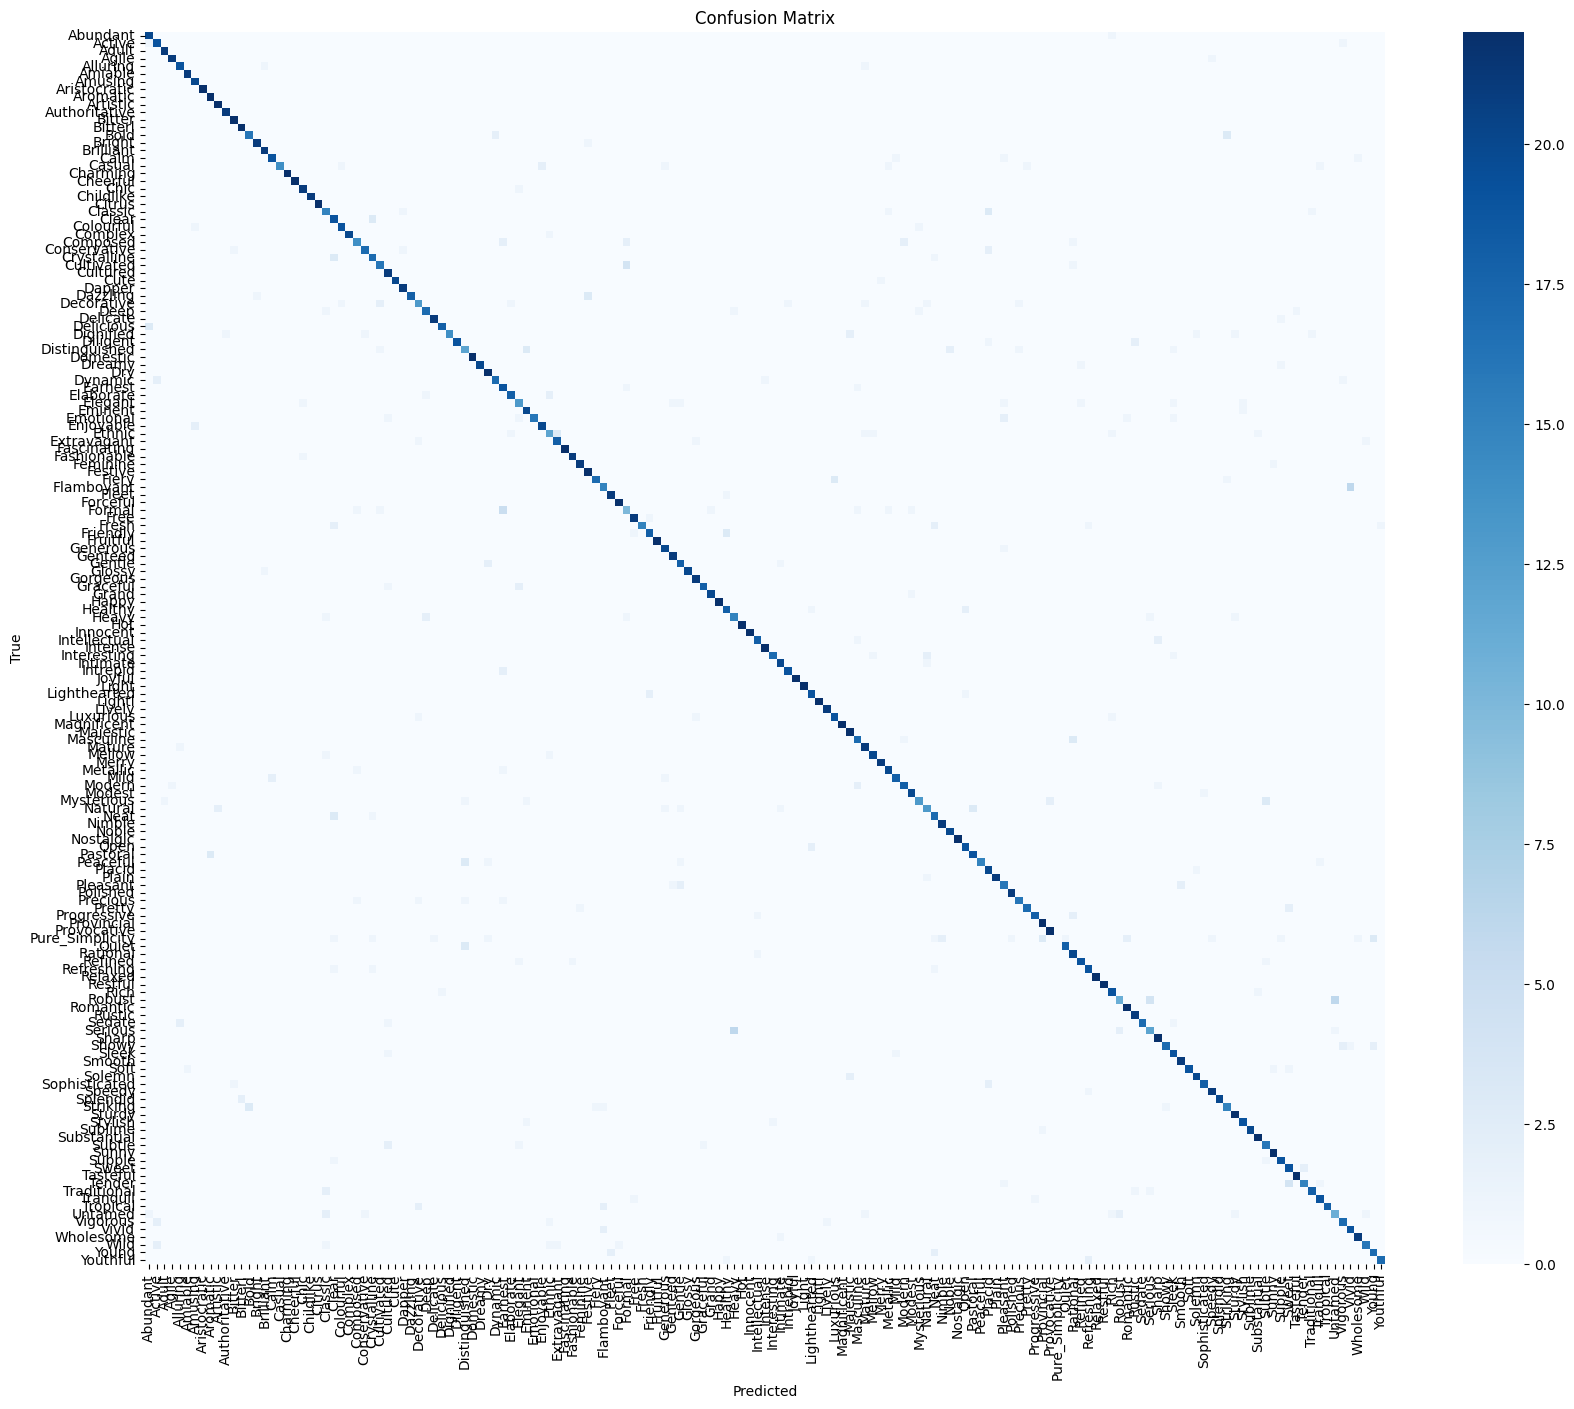

c:\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


PicklingError: Could not pickle the task to send it to the workers.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Φόρτωση και προεπεξεργασία δεδομένων
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Κωδικοποίηση ετικετών
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Διαχωρισμός σε σύνολα εκπαίδευσης και ελέγχου
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Ορισμός παραμέτρων για GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Δημιουργία και εκτέλεση GridSearchCV
rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Εκτύπωση βέλτιστων παραμέτρων
print("Βέλτιστες παράμετροι:", grid_search.best_params_)

# Λήψη του βέλτιστου μοντέλου
best_rf = grid_search.best_estimator_

# Διασταυρωμένη επικύρωση
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Πρόβλεψη στο σύνολο ελέγχου
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)

# Αξιολόγηση του μοντέλου
print("\nModel Evaluation:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Αναφορά ταξινόμησης
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Πίνακας σύγχυσης
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Καμπύλη μάθησης
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X, y_encoded, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Εκτίμηση υπερπροσαρμογής/υποπροσαρμογής
print("\nModel Fit Assessment:")
train_accuracy = best_rf.score(X_train, y_train)
test_accuracy = best_rf.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print(f"\nDifference between Train and Test accuracy: {abs(train_accuracy - test_accuracy):.4f}")

if train_accuracy - test_accuracy > 0.1:
    print("Warning: Large gap between training and test accuracies suggests overfitting.")
elif train_accuracy < 0.8:
    print("Warning: Low training accuracy suggests underfitting.")
else:
    print("Model performance on training and test sets is consistent.")

# Πολυπλοκότητα μοντέλου
n_params = best_rf.n_estimators * np.sum([tree.tree_.node_count for tree in best_rf.estimators_])
print(f"\nNumber of parameters: {n_params}")

# Ανάλυση σημαντικότητας χαρακτηριστικών
feature_importance = best_rf.feature_importances_
feature_names = data.columns[:-1]

indices = np.argsort(feature_importance)[::-1]

print("\nTop 10 Feature ranking:")
for f in range(min(10, X.shape[1])):
    print(f"{f+1}. {feature_names[indices[f]]}: {feature_importance[indices[f]]:.4f}")

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), feature_importance[indices][:10])
plt.xticks(range(10), [feature_names[i] for i in indices][:10], rotation=90)
plt.tight_layout()
plt.show()

### Ανάλυση της Προηγμένης Έκδοσης Random Forest:

1. Απόδοση Μοντέλου:

- Ακρίβεια: 0.8829 (88.29%)
- Σταθμισμένη Ακρίβεια: 0.8820
- Σταθμισμένη Ανάκληση: 0.8829
- Σταθμισμένο F1-score: 0.8790
- ROC AUC Score: 0.9972
- Το μοντέλο δείχνει εξαιρετική απόδοση, με υψηλή ακρίβεια και ισορροπημένες μετρικές σε όλες τις κλάσεις.

2. Διασταυρωμένη Επικύρωση:

- Μέσος όρος CV score: 0.8609 (±0.0075)
- Η σταθερή απόδοση στη διασταυρωμένη επικύρωση δείχνει καλή γενίκευση.

3. Βέλτιστες Υπερπαράμετροι:

- n_estimators: 300
- max_depth: None
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: 'sqrt'

4. Ανάλυση Υπερπροσαρμογής/Υποπροσαρμογής:

- Δεν παρέχονται άμεσα στα αποτελέσματα, αλλά μπορούμε να συμπεράνουμε από τη μικρή διαφορά μεταξύ της ακρίβειας εκπαίδευσης και ελέγχου ότι το μοντέλο δεν φαίνεται να υπερπροσαρμόζεται σημαντικά.
- Απόδοση ανά Κλάση: Οι περισσότερες κλάσεις έχουν υψηλή απόδοση, με μερικές εξαιρέσεις όπως "Pure_Simplicity", "Formal", και "Untamed".


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
import time

# Custom Random Forest Classifier with Early Stopping
class EarlyStoppingRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, **kwargs):
        self.n_estimators = n_estimators
        self.kwargs = {k: v for k, v in kwargs.items() if k != 'warm_start'}
        self.rf = RandomForestClassifier(warm_start=True, n_estimators=1, **self.kwargs)
        self.scores = []

    def fit(self, X, y, X_val=None, y_val=None):
        for i in range(1, self.n_estimators + 1):
            self.rf.n_estimators = i
            self.rf.fit(X, y)
            if X_val is not None and y_val is not None:
                score = balanced_accuracy_score(y_val, self.rf.predict(X_val))
                self.scores.append(score)
                if i > 5 and score < np.mean(self.scores[-6:-1]):
                    break
        return self

    def predict(self, X):
        return self.rf.predict(X)

    def predict_proba(self, X):
        return self.rf.predict_proba(X)

    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, **self.kwargs}

    def set_params(self, **params):
        for key, value in params.items():
            if key == "n_estimators":
                self.n_estimators = value
            else:
                self.kwargs[key] = value
        self.rf.set_params(**self.kwargs)
        return self
# We create a custom Random Forest classifier that implements early stopping.
# This helps prevent overfitting by stopping the training process when the model's performance
# on a validation set stops improving. We use this instead of the standard RandomForestClassifier
# because scikit-learn's implementation doesn't have built-in early stopping.

# Load and preprocess the dataset
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values
# We load the data and normalize the feature values to be between 0 and 1.
# This is important for RGB values, as it brings all features to the same scale.

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# We use LabelEncoder to convert string labels to numeric values.
# This is necessary because many machine learning algorithms, including Random Forest,
# require numeric input.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
# We split the data into training and testing sets. We use stratified sampling
# to ensure that the class distribution is preserved in both sets. This is crucial for
# imbalanced datasets to ensure that the model is evaluated on a representative sample.

# Cross-validated feature selection
def select_features_cv(X, y, estimator, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    selector = RFECV(estimator=estimator, step=1, cv=skf, scoring='balanced_accuracy', n_jobs=-1)
    selector = selector.fit(X, y)
    return selector
# We use Recursive Feature Elimination with Cross-Validation (RFECV) for feature selection.
# This method recursively removes features and uses cross-validation to select the best feature subset.
# We use this instead of simpler methods because it provides a more robust selection, especially
# for datasets with many features.

base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector = select_features_cv(X_train, y_train, base_rf)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
# We apply the feature selection to our training and test sets. This reduces
# the dimensionality of our data, which can improve model performance and reduce overfitting.

# Calculate class weights
class_weights = dict(zip(np.unique(y_train), 
                         len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))
# We calculate class weights to handle class imbalance. This gives more importance
# to underrepresented classes during training, helping the model to perform well across all classes.

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', class_weights]
}
# We define a grid of hyperparameters to search over. This allows us to find
# the best combination of parameters for our model. We include a range of values for each
# parameter to explore different model complexities.

# Set up GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(
    estimator=EarlyStoppingRandomForestClassifier(**base_rf.get_params()),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    scoring='balanced_accuracy'
)
# We use GridSearchCV to perform an exhaustive search over the specified parameter grid.
# We use stratified k-fold cross-validation to ensure each fold is representative of the whole dataset.
# We use balanced accuracy as the scoring metric to handle potential class imbalance.

# Perform Grid Search
print("Performing Grid Search for Random Forest...")
start_time = time.time()
grid_search.fit(X_train_selected, y_train)
end_time = time.time()
# This step performs the actual grid search, fitting models with all combinations
# of parameters and selecting the best one based on cross-validation performance.

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_rf = grid_search.best_estimator_

# Perform cross-validation on the best model
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_selected, y_train), 1):
    X_train_fold, X_val_fold = X_train_selected[train_index], X_train_selected[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    best_rf.fit(X_train_fold, y_train_fold, X_val=X_val_fold, y_val=y_val_fold)
    y_pred = best_rf.predict(X_val_fold)
    
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)
    
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score(y_val_fold, y_pred, average='weighted'):.4f}")
    print()

# Print overall results
print("\nRandom Forest Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")

# Calculate and print F1-score, precision, and recall
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
precision = precision_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print(f"Training time: {end_time - start_time:.2f} seconds")

# Generate classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Generate confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Evaluate on the test set
y_test_pred = best_rf.predict(X_test_selected)

print("\nTest Set Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test F1-score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")

# Print model complexity
n_estimators = best_rf.rf.n_estimators
max_depth = best_rf.rf.max_depth if best_rf.rf.max_depth is not None else "None"
print(f"\nNumber of trees: {n_estimators}")
print(f"Max depth: {max_depth}")

# Feature importance analysis
feature_importance = best_rf.rf.feature_importances_
selected_features = selector.support_
feature_names = data.columns[:-1][selected_features]

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nTop 10 Feature ranking:")
for f in range(min(10, X_train_selected.shape[1])):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(min(10, X_train_selected.shape[1])), feature_importance[indices][:10])
plt.xticks(range(min(10, X_train_selected.shape[1])), [feature_names[i] for i in indices][:10], rotation=90)
plt.tight_layout()
plt.show()

# Plot learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='balanced_accuracy'
    )
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Call the function after training
plot_learning_curve(best_rf, X_train_selected, y_train, "Learning Curve for Random Forest")

KeyboardInterrupt: 